### Реализуем класс MyMLP при помощи библиотеки numpy

In [1]:
import numpy as np

In [2]:
class MyMLP:
    def __init__(self,
                 layer_sizes,          # [in, ..., out]
                 activations,          # ['relu','sigmoid','linear',...]
                 task='regression',    # 'regression' | 'binary' | 'multiclass'
                 lr=1e-3,              
                 batch_size=None,      
                 reg_lambda=0.0,       
                 reg_type='L2'):       
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.task = task
        self.lr = lr
        self.batch_size = batch_size or 0
        self.reg_lambda = reg_lambda
        self.reg_type = reg_type
        
        self._init_weights()
        self._print_grad_formulas()
    
    def _init_weights(self):
        self.W, self.b = [], []
        for i in range(len(self.layer_sizes)-1):
            fan_in = self.layer_sizes[i]
            fan_out = self.layer_sizes[i+1]
            W = np.random.randn(fan_in, fan_out) * np.sqrt(2.0/fan_in)
            b = np.zeros((1, fan_out))
            self.W.append(W)
            self.b.append(b)
    
    def _print_grad_formulas(self):
        print("**Backward formulas**\n"
              "Z[l] = A[l-1]·W[l] + b[l]\n"
              "A[l] = g[l](Z[l])\n"
              "MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m\n"
              "CE(multi): dZ[L]=A[L]-Y\n"
              "dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]\n"
              "db[l]=∑dZ[l]\n"
              "W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]\n"
              "---")
    
    def _activate(self, Z, kind):
        if kind=='relu': return np.maximum(0, Z)
        if kind=='sigmoid': return 1/(1+np.exp(-Z))
        if kind=='linear': return Z
        raise ValueError
    
    def _activate_grad(self, A, kind):
        if kind=='relu': return (A>0).astype(float)
        if kind=='sigmoid': return A*(1-A)
        if kind=='linear': return np.ones_like(A)
        raise ValueError
    
    def _compute_loss_and_grad(self, A_last, Y):
        m = Y.shape[0]
        if self.task=='regression':
            loss = np.mean((A_last-Y)**2)
            dA = 2*(A_last-Y)/m
        else:
            eps = 1e-8
            A_clip = np.clip(A_last, eps, 1-eps)
            if self.task=='binary':
                loss = -np.mean(Y*np.log(A_clip)+(1-Y)*np.log(1-A_clip))
                dA = (A_last - Y)/(A_last*(1-A_last)*m)
            else:
                # multiclass softmax+CE
                exps = np.exp(A_last - A_last.max(axis=1, keepdims=True))
                probs = exps/ exps.sum(axis=1, keepdims=True)
                loss = -np.mean(np.sum(Y*np.log(probs+eps), axis=1))
                dA = (probs - Y)/m
        return loss, dA
    
    def _add_regularization(self, dW, W):
        if self.reg_lambda == 0:
            return dW
        if 'L1' in self.reg_type:
            dW += self.reg_lambda * np.sign(W)
        if 'L2' in self.reg_type:
            dW += 2 * self.reg_lambda * W
        return dW
    
    def forward(self, X):
        A = X
        self.caches = [(None, X)]
        for W, b, act in zip(self.W, self.b, self.activations):
            Z = A.dot(W) + b
            A = self._activate(Z, act)
            self.caches.append((Z, A))
        return A
    
    def backward(self, dA):
        grads_W, grads_b = [], []
        for l in reversed(range(len(self.W))):
            Z_prev, A_prev = self.caches[l]
            Z_cur, A_cur = self.caches[l+1]
            dZ = dA * self._activate_grad(A_cur, self.activations[l])
            dW = A_prev.T.dot(dZ)
            db = dZ.sum(axis=0, keepdims=True)
            dW = self._add_regularization(dW, self.W[l])
            grads_W.insert(0, dW)
            grads_b.insert(0, db)
            dA = dZ.dot(self.W[l].T)
        return grads_W, grads_b
    
    def update_params(self, grads_W, grads_b):
        for i in range(len(self.W)):
            self.W[i] -= self.lr * grads_W[i]
            self.b[i] -= self.lr * grads_b[i]
    
    def fit(self, X, Y, epochs=500, verbose=False):
        m = X.shape[0]
        batch = self.batch_size or m
        for ep in range(1, epochs+1):
            perm = np.random.permutation(m)
            X_sh, Y_sh = X[perm], Y[perm]
            epoch_loss = 0
            for i in range(0, m, batch):
                xb, yb = X_sh[i:i+batch], Y_sh[i:i+batch]
                A = self.forward(xb)
                loss, dA = self._compute_loss_and_grad(A, yb)
                grads_W, grads_b = self.backward(dA)
                self.update_params(grads_W, grads_b)
                epoch_loss += loss * xb.shape[0]
            epoch_loss /= m
            if verbose and ep % (epochs//10 or 1)==0:
                print(f"Epoch {ep}/{epochs} loss={epoch_loss:.4f}")
    
    def predict(self, X):
        A = self.forward(X)
        if self.task=='regression':
            return A
        if self.task=='binary':
            return (A>0.5).astype(int)
        if self.task=='multiclass':
            return np.argmax(A, axis=1)

### Проверим реализацию на примере 

In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, r2_score,
    accuracy_score, f1_score
)
from sklearn.neural_network import MLPRegressor, MLPClassifier

C:\Users\1\AppData\Local\Temp\ipykernel_14200\4185698213.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


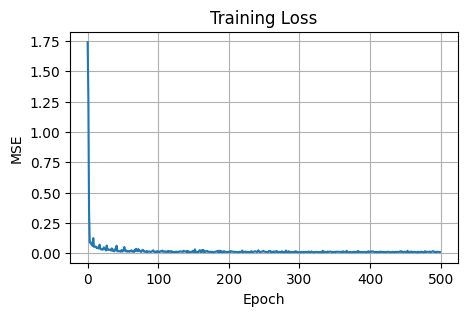

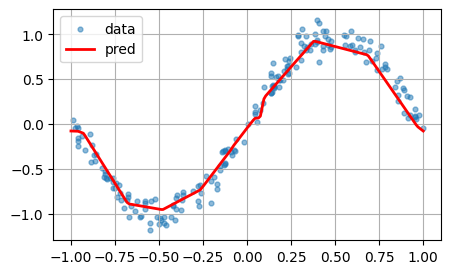

In [4]:
np.random.seed(0)
X = np.random.uniform(-1, 1, (200,1))
y = np.sin(np.pi * X) + 0.1*np.random.randn(200,1)

X_mean, X_std = X.mean(), X.std()
X_norm = (X - X_mean)/X_std

X_tr, X_te, y_tr, y_te = train_test_split(
    X_norm, y, test_size=0.3, random_state=42
)

model = MyMLP(
    layer_sizes=[1,32,32,1],
    activations=['relu','relu','linear'],
    task='regression',
    lr=0.1,
    batch_size=32,
    reg_lambda=0.0,
    reg_type='L2'
)

history = []
for ep in range(500):
    perm = np.random.permutation(X_tr.shape[0])
    Xb, yb = X_tr[perm], y_tr[perm]
    loss, _ = model._compute_loss_and_grad(model.forward(Xb), yb)
    model.fit(X_tr, y_tr, epochs=1, verbose=False)
    history.append(loss)

plt.figure(figsize=(5,3))
plt.plot(history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.show()

X_grid = np.linspace(-1,1,200).reshape(-1,1)
X_grid_norm = (X_grid - X_mean)/X_std
y_pred = model.predict(X_grid_norm)

plt.figure(figsize=(5,3))
plt.scatter(X, y, s=12, alpha=0.5, label='data')
plt.plot(X_grid, y_pred, 'r-', linewidth=2, label='pred')
plt.legend()
plt.grid()
plt.show()

In [6]:
t0 = time.time()
model.fit(X_tr, y_tr, epochs=500, verbose=False)
t_my_train = time.time() - t0

t1 = time.time()
y_my = model.predict(X_te)
t_my_inf = time.time() - t1

mae_my = mean_absolute_error(y_te, y_my)
r2_my  = r2_score(y_te, y_my)

# sklearn
skl = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    learning_rate_init=0.1,
    max_iter=500,
    alpha=0.0,
    random_state=0
)
t0 = time.time()
skl.fit(X_tr, y_tr.ravel())
t_skl_train = time.time() - t0

t1 = time.time()
y_skl = skl.predict(X_te).reshape(-1,1)
t_skl_inf = time.time() - t1

mae_skl = mean_absolute_error(y_te, y_skl)
r2_skl  = r2_score(y_te, y_skl)

df = pd.DataFrame([
    {'framework':'MyMLP',   'train_time':t_my_train, 'infer_time':t_my_inf, 'MAE':mae_my, 'R2':r2_my},
    {'framework':'sklearn', 'train_time':t_skl_train,'infer_time':t_skl_inf,'MAE':mae_skl,'R2':r2_skl}
])
df

,framework,train_time,infer_time,MAE,R2
0,MyMLP,0.287228,0.0,0.085980,0.977721
1,sklearn,0.027925,0.0,0.079324,0.980467


### Пример регрессии на датасете Used_fiat_500_in_Italy_dataset

In [9]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score

In [10]:
param_grid = [
    {'name':'real1','layers':[6,32,1],    'activ':['relu','linear'],   'lr':0.01,  'reg':0.0,     'reg_type':'L2'},
    {'name':'real2','layers':[6,64,32,1], 'activ':['relu','relu','linear'], 'lr':0.005, 'reg':1e-4, 'reg_type':'L2'},
    {'name':'real3','layers':[6,32,16,1], 'activ':['relu','relu','linear'], 'lr':0.001, 'reg':1e-3, 'reg_type':'L2'},
    {'name':'real4','layers':[6,128,64,32,1], 'activ':['relu','relu','relu','linear'], 'lr':0.003, 'reg':1e-4, 'reg_type':'L2'},
    {'name':'real5','layers':[6,64,64,1],      'activ':['relu','relu','linear'],        'lr':0.0005, 'reg':1e-3, 'reg_type':'L2'},
    {'name':'real6_l1','layers':[6,64,1],   'activ':['relu','linear'],  'lr':0.005,  'reg':1e-3, 'reg_type':'L1'},
    {'name':'real7_l1l2','layers':[6,64,32,1],'activ':['relu','relu','linear'],'lr':0.003, 'reg':1e-3, 'reg_type':'L1L2'},
    {'name':'real8_noreg','layers':[6,32,1],  'activ':['relu','linear'],  'lr':0.01,  'reg':0.0,  'reg_type':None},
]

In [11]:
df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')
needed = ['engine_power','age_in_days','km','previous_owners','lat','lon','price']
df = df[needed].dropna()

X = df[['engine_power','age_in_days','km','previous_owners','lat','lon']].values
y = df['price'].values.reshape(-1,1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_tr = scaler_X.fit_transform(X_tr)
X_te = scaler_X.transform(X_te)

scaler_y = StandardScaler()
y_tr_s = scaler_y.fit_transform(y_tr)
y_te_s = scaler_y.transform(y_te)


results = []

for cfg in param_grid:
    name = cfg['name']
    layers = cfg['layers']
    activs = cfg['activ']
    lr     = cfg['lr']
    reg_l  = cfg['reg']

    # --- MyMLP ---
    mlp = MyMLP(
        layer_sizes=layers,
        activations=activs,
        task='regression',
        lr=lr,
        batch_size=32,
        reg_lambda=reg_l,
        reg_type='L2'
    )
    t0 = time.time()
    mlp.fit(X_tr, y_tr_s, epochs=500, verbose=False)
    t_train = time.time() - t0

    t1 = time.time()
    pred_s = mlp.predict(X_te)
    t_inf = time.time() - t1

    y_pred = scaler_y.inverse_transform(pred_s)

    results.append({
        'cfg': name, 'framework':'MyMLP',
        'train_time': t_train,
        'infer_time': t_inf,
        'MAE': mean_absolute_error(y_te, y_pred),
        'R2': r2_score(y_te, y_pred)
    })

    # --- sklearn ---
    skl = MLPRegressor(
        hidden_layer_sizes=tuple(layers[1:-1]),
        activation='relu',
        learning_rate_init=lr,
        alpha=reg_l,
        max_iter=500,
        random_state=42
    )
    t0 = time.time()
    skl.fit(X_tr, y_tr_s.ravel())
    t_train = time.time() - t0

    t1 = time.time()
    pred_s2 = skl.predict(X_te).reshape(-1,1)
    t_inf = time.time() - t1
    y_pred2 = scaler_y.inverse_transform(pred_s2)

    results.append({
        'cfg': name, 'framework':'sklearn',
        'train_time': t_train,
        'infer_time': t_inf,
        'MAE': mean_absolute_error(y_te, y_pred2),
        'R2':  r2_score(y_te, y_pred2)
    })

    # --- TensorFlow  ---
    X_tr_tf = tf.constant(X_tr, dtype=tf.float32)
    y_tr_tf = tf.constant(y_tr_s, dtype=tf.float32)
    X_te_tf = tf.constant(X_te, dtype=tf.float32)

    Ws, bs = [], []
    for i in range(len(layers)-1):
        fin, fout = layers[i], layers[i+1]
        W = tf.Variable(tf.random.normal([fin,fout], stddev=tf.sqrt(2.0/fin)))
        b = tf.Variable(tf.zeros([fout]))
        Ws.append(W); bs.append(b)
    opt = tf.optimizers.SGD(lr)

    t0 = time.time()
    for epoch in range(500):
        with tf.GradientTape() as tape:
            A = X_tr_tf
            for W, b, act in zip(Ws, bs, activs):
                Z = tf.matmul(A, W) + b
                if act=='relu': A = tf.nn.relu(Z)
                elif act=='sigmoid': A = tf.sigmoid(Z)
                else: A = Z
            loss = tf.reduce_mean((A - y_tr_tf)**2)
        grads = tape.gradient(loss, Ws+bs)
        opt.apply_gradients(zip(grads, Ws+bs))
    t_tf = time.time() - t0

    t1 = time.time()
    A = X_te_tf
    for W, b, act in zip(Ws, bs, activs):
        Z = tf.matmul(A, W) + b
        if act=='relu': A = tf.nn.relu(Z)
        elif act=='sigmoid': A = tf.sigmoid(Z)
        else: A = Z
    y_tf = scaler_y.inverse_transform(A.numpy())
    it_tf = time.time() - t1

    results.append({
        'cfg': name, 'framework':'TensorFlow',
        'train_time': t_tf,
        'infer_time': it_tf,
        'MAE': mean_absolute_error(y_te, y_tf),
        'R2': r2_score(y_te, y_tf)
    })

    # --- Keras ---
    model_k = keras.Sequential()
    for i, hid in enumerate(layers[1:-1]):
        model_k.add(keras.layers.Dense(hid,
            activation=activs[i], input_shape=(layers[0],)))
    model_k.add(keras.layers.Dense(layers[-1], activation='linear'))
    model_k.compile(optimizer=keras.optimizers.SGD(lr), loss='mse')

    t0 = time.time()
    model_k.fit(X_tr, y_tr_s, epochs=500, batch_size=32, verbose=0)
    t_k = time.time() - t0

    t1 = time.time()
    y_k = scaler_y.inverse_transform(model_k.predict(X_te, verbose=0))
    it_k = time.time() - t1

    results.append({
        'cfg': name, 'framework':'Keras',
        'train_time': t_k,
        'infer_time': it_k,
        'MAE': mean_absolute_error(y_te, y_k),
        'R2': r2_score(y_te, y_k)
    })

    # --- PyTorch ---
    X_tr_t = torch.from_numpy(X_tr.astype(np.float32))
    y_tr_t = torch.from_numpy(y_tr_s.astype(np.float32))
    X_te_t = torch.from_numpy(X_te.astype(np.float32))

    class TorchNet(nn.Module):
        def __init__(self):
            super().__init__()
            layers_list = []
            for i in range(len(layers)-1):
                fin, fout = layers[i], layers[i+1]
                layers_list.append(nn.Linear(fin, fout))
                if i < len(layers)-2:
                    if activs[i]=='relu':
                        layers_list.append(nn.ReLU())
                    elif activs[i]=='sigmoid':
                        layers_list.append(nn.Sigmoid())
            self.net = nn.Sequential(*layers_list)
        def forward(self, x):
            return self.net(x)

    net = TorchNet()
    opt_t = optim.SGD(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    t0 = time.time()
    for epoch in range(500):
        opt_t.zero_grad()
        pred = net(X_tr_t)
        loss = loss_fn(pred, y_tr_t)
        loss.backward()
        opt_t.step()
    t_pt = time.time() - t0

    t1 = time.time()
    y_pt = scaler_y.inverse_transform(net(X_te_t).detach().numpy())
    it_pt = time.time() - t1

    results.append({
        'cfg': name, 'framework':'PyTorch',
        'train_time': t_pt,
        'infer_time': it_pt,
        'MAE': mean_absolute_error(y_te, y_pt),
        'R2':  r2_score(y_te, y_pt)
    })

df_results = pd.DataFrame(results)
display(df_results)

**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,cfg,framework,train_time,infer_time,MAE,R2
0,real1,MyMLP,0.483704,0.000000,560.207910,0.900650
1,real1,sklearn,0.140626,0.000000,534.746195,0.905456
2,real1,TensorFlow,2.778137,0.000997,582.393555,0.892435
3,real1,Keras,14.367636,0.082897,516.777771,0.905220
4,real1,PyTorch,0.323112,0.000995,562.000854,0.892933
5,real2,MyMLP,0.721024,0.000000,593.037512,0.891771
6,real2,sklearn,0.486551,0.000000,590.894599,0.880578
7,real2,TensorFlow,3.695296,0.001000,636.955994,0.857467
8,real2,Keras,14.603849,0.098075,544.636169,0.906474
9,real2,PyTorch,0.407908,0.000000,541.285583,0.901310


### Многоклассовая классификация

In [11]:
from tensorflow.keras.datasets import mnist

(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X_tr = X_tr.reshape(-1, 28*28) / 255.0
X_te = X_te.reshape(-1, 28*28) / 255.0

Y_tr_oh = np.eye(10)[y_tr]
Y_te_oh = np.eye(10)[y_te]

param_grid = [
    {'name': 'mnist1', 'layers': [784, 128, 10], 'activ': ['relu', 'linear'], 'lr': 0.01, 'reg': 1e-4},
    {'name': 'mnist2', 'layers': [784, 256, 128, 10], 'activ': ['relu', 'relu', 'linear'], 'lr': 0.005, 'reg': 1e-4},
]

results = []

for cfg in param_grid:
    name, layers, activs, lr, reg_l = cfg.values()

    # --- MyMLP ---
    mlp = MyMLP(
        layer_sizes=layers,
        activations=activs,
        task='multiclass',
        lr=lr,
        batch_size=128,
        reg_lambda=reg_l,
        reg_type='L2'
    )
    t0 = time.time()
    mlp.fit(X_tr, Y_tr_oh, epochs=10, verbose=False)
    t_train = time.time() - t0

    t1 = time.time()
    y_pred_mlp = mlp.predict(X_te)
    t_inf = time.time() - t1

    results.append({
        'cfg': name, 'framework': 'MyMLP',
        'train_time': t_train, 'infer_time': t_inf,
        'Accuracy': accuracy_score(y_te, y_pred_mlp),
        'F1': f1_score(y_te, y_pred_mlp, average='macro')
    })

    # --- sklearn ---
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers[1:-1]), activation='relu',
                        learning_rate_init=lr, alpha=reg_l, max_iter=20, random_state=42)
    t0 = time.time()
    clf.fit(X_tr, y_tr)
    t_train = time.time() - t0

    t1 = time.time()
    y_pred = clf.predict(X_te)
    t_inf = time.time() - t1

    results.append({
        'cfg': name, 'framework': 'sklearn',
        'train_time': t_train, 'infer_time': t_inf,
        'Accuracy': accuracy_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred, average='macro')
    })

    # --- Keras ---
    model_k = keras.Sequential()
    model_k.add(keras.layers.Input(shape=(784,)))
    for i, size in enumerate(layers[1:-1]):
        model_k.add(keras.layers.Dense(size, activation=activs[i]))
    model_k.add(keras.layers.Dense(10, activation='softmax'))
    model_k.compile(optimizer=keras.optimizers.SGD(learning_rate=lr),
                    loss='categorical_crossentropy', metrics=['accuracy'])

    t0 = time.time()
    model_k.fit(X_tr, Y_tr_oh, epochs=10, batch_size=64, verbose=0)
    t_train = time.time() - t0

    t1 = time.time()
    y_pred_keras = np.argmax(model_k.predict(X_te, verbose=0), axis=1)
    t_inf = time.time() - t1

    results.append({
        'cfg': name, 'framework': 'Keras',
        'train_time': t_train, 'infer_time': t_inf,
        'Accuracy': accuracy_score(y_te, y_pred_keras),
        'F1': f1_score(y_te, y_pred_keras, average='macro')
    })

    # --- TensorFlow ---
    X_tr_tf = tf.constant(X_tr, dtype=tf.float32)
    y_tr_tf = tf.constant(Y_tr_oh, dtype=tf.float32)
    X_te_tf = tf.constant(X_te, dtype=tf.float32)

    Ws, bs = [], []
    for i in range(len(layers) - 1):
        fin, fout = layers[i], layers[i + 1]
        W = tf.Variable(tf.random.normal([fin, fout], stddev=tf.sqrt(2.0 / fin)))
        b = tf.Variable(tf.zeros([fout]))
        Ws.append(W)
        bs.append(b)

    opt = tf.optimizers.Adam(learning_rate=lr)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_tf, y_tr_tf)).shuffle(1024).batch(128)

    def softmax(x):
        e = tf.exp(x - tf.reduce_max(x, axis=1, keepdims=True))
        return e / tf.reduce_sum(e, axis=1, keepdims=True)

    t0 = time.time()
    for epoch in range(20):
        for xb, yb in train_dataset:
            with tf.GradientTape() as tape:
                A = xb
                for W, b, act in zip(Ws, bs, activs):
                    Z = tf.matmul(A, W) + b
                    if act == 'relu':
                        A = tf.nn.relu(Z)
                    elif act == 'sigmoid':
                        A = tf.sigmoid(Z)
                    else:
                        A = Z
                probs = softmax(A)
                loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(yb, probs))
            grads = tape.gradient(loss, Ws + bs)
            opt.apply_gradients(zip(grads, Ws + bs))
    t_train = time.time() - t0

    t1 = time.time()
    A = X_te_tf
    for W, b, act in zip(Ws, bs, activs):
        Z = tf.matmul(A, W) + b
        if act == 'relu':
            A = tf.nn.relu(Z)
        elif act == 'sigmoid':
            A = tf.sigmoid(Z)
        else:
            A = Z
    y_tf = tf.argmax(A, axis=1).numpy()
    t_inf = time.time() - t1

    results.append({
        'cfg': name, 'framework': 'TensorFlow-Improved',
        'train_time': t_train, 'infer_time': t_inf,
        'Accuracy': accuracy_score(y_te, y_tf),
        'F1': f1_score(y_te, y_tf, average='macro')
    })

    # --- PyTorch ---
    class TorchNet(nn.Module):
        def __init__(self):
            super().__init__()
            layers_list = []
            for i in range(len(layers) - 1):
                layers_list.append(nn.Linear(layers[i], layers[i + 1]))
                if i < len(layers) - 2:
                    layers_list.append(nn.ReLU())
            self.net = nn.Sequential(*layers_list)

        def forward(self, x):
            return self.net(x)

    X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr, dtype=torch.long)
    X_te_t = torch.tensor(X_te, dtype=torch.float32)
    
    net = TorchNet()
    opt_t = optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_ds = TensorDataset(X_tr_t, y_tr_t)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)

    net.train()
    t0 = time.time()
    for epoch in range(20):
        for xb, yb in train_loader:
            opt_t.zero_grad()
            pred = net(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt_t.step()
    t_train = time.time() - t0

    net.eval()
    t1 = time.time()
    with torch.no_grad():
        y_pt = net(X_te_t).argmax(dim=1).numpy()
    t_inf = time.time() - t1

    results.append({
        'cfg': name, 'framework': 'PyTorch-Improved',
        'train_time': t_train, 'infer_time': t_inf,
        'Accuracy': accuracy_score(y_te, y_pt),
        'F1': f1_score(y_te, y_pt, average='macro')
    })


df_results = pd.DataFrame(results)
df_results


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


**Backward formulas**
Z[l] = A[l-1]·W[l] + b[l]
A[l] = g[l](Z[l])
MSE: L=1/m·∑(A[L]-Y)^2, dA[L]=2(A[L]-Y)/m
CE(multi): dZ[L]=A[L]-Y
dW[l]=A[l-1]^T·dZ[l] + λ·2W[l]
db[l]=∑dZ[l]
W[l]←W[l]-η·dW[l], b[l]←b[l]-η·db[l]
---


c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


,cfg,framework,train_time,infer_time,Accuracy,F1
0,mnist1,MyMLP,18.234293,0.127661,0.9227,0.921605
1,mnist1,sklearn,71.076921,0.101725,0.9742,0.973907
2,mnist1,Keras,20.122736,0.948283,0.9371,0.936365
3,mnist1,TensorFlow-Improved,593.736414,0.017953,0.9742,0.974036
4,mnist1,PyTorch-Improved,81.030139,0.043883,0.9699,0.969727
5,mnist2,MyMLP,59.960423,0.207443,0.9260,0.925020
6,mnist2,sklearn,159.876792,0.177061,0.9748,0.974615
7,mnist2,Keras,36.405049,1.167417,0.9395,0.938646
8,mnist2,TensorFlow-Improved,746.285158,0.046874,0.9777,0.977500
9,mnist2,PyTorch-Improved,123.408687,0.091756,0.9790,0.978856
